In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [2]:
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNet

In [3]:
#!pip install lightgbm
#!pip install catboost

In [4]:
from sklearn.feature_selection import mutual_info_regression

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import StackingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score
import lightgbm as lgb
from catboost import CatBoostRegressor

In [6]:
hard = pd.read_csv("hardness_composition_data_remove1200.csv")
hard_ip = hard.drop(columns = ["HV"])
hard_op = hard["HV"]

<Axes: >

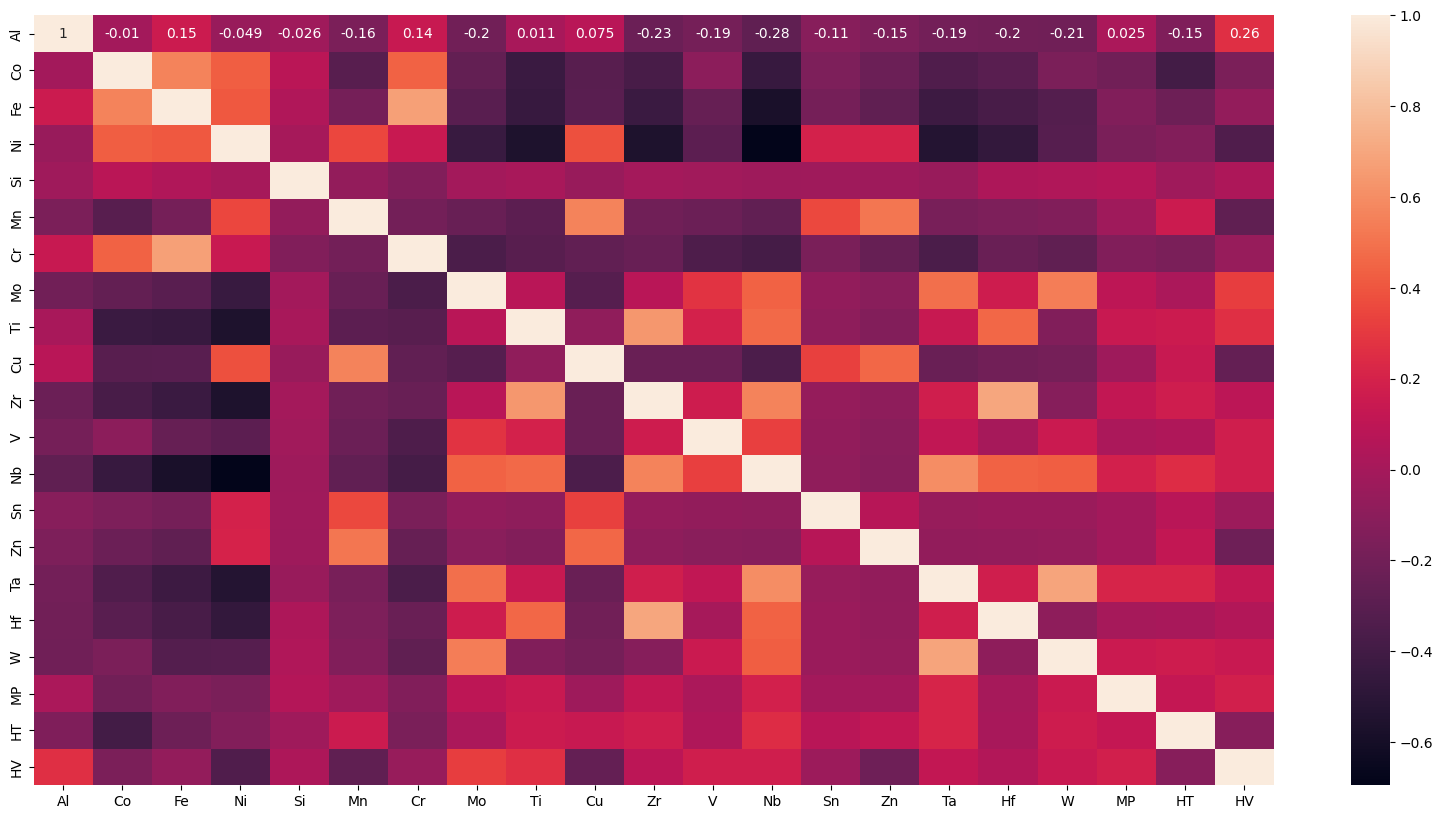

In [7]:
import seaborn as sns
plt.figure(figsize = (20,10))
sns.heatmap(hard.corr(), annot = True)

In [8]:
import numpy as np
import statsmodels.api as sm

def select_insignificant_features(X, y, input_features):
    # Add a constant term to the input features matrix
    X_with_const = sm.add_constant(X)
    
    # Fit ordinary least squares (OLS) model
    model = sm.OLS(y, X_with_const)
    results = model.fit()
    
    # Extract p-values for each coefficient
    p_values = results.pvalues[1:]  # Exclude the constant term
    
    # Identify features with p-values greater than the threshold
    insignificant_features = [input_features[i] for i, p_value in enumerate(p_values) if p_value > 0.5]
    
    return insignificant_features


def select_insignificant_features_mutual_info(X, y, input_features, threshold=0.1):
    # Compute mutual information between each feature and the target
    mi = mutual_info_regression(X, y)
    
    # Identify features with mutual information less than the threshold
    insignificant_features = [input_features[i] for i, mi_value in enumerate(mi) if mi_value < threshold]
    
    return insignificant_features


input_features = hard_ip.columns
output_feature = 'HV'

insignificant_features = select_insignificant_features(hard_ip, hard_op, input_features)
print("Insignificant Features:", insignificant_features)


insignificant_features_mutual_info = select_insignificant_features_mutual_info(hard_ip, hard_op, input_features)
print("Insignificant Features (Mutual Information):", insignificant_features_mutual_info)


Insignificant Features: []
Insignificant Features (Mutual Information): ['Si', 'Sn', 'Zn', 'Hf', 'MP', 'HT']


In [9]:
# %pip install statsmodels
# We can remove the insignificant features if we want

In [10]:
X = hard_ip
y = hard_op

In [11]:
# param_grids = {
#         'lr': {
#             'model__regressor__fit_intercept': [True, False],
#         },
#         'ridge': {
#             'model__regressor__alpha': [0.1, 1.0, 10.0],
#             'model__regressor__fit_intercept': [True, False],
#             'model__regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
#         },
#         'lasso': {
#             'model__regressor__alpha': [0.01, 0.1, 1.0],
#             'model__regressor__fit_intercept': [True, False],
#             'model__regressor__positive': [True, False],
#             'model__regressor__selection': ['cyclic', 'random']
#         },
#         'rf': {
#             'model__regressor__n_estimators': [10, 20, 30],
#             'model__regressor__max_depth': [2, 5, 10],
#             'model__regressor__min_samples_split': [2, 5, 10],
#             'model__regressor__min_samples_leaf': [1, 2, 4]
#         },
#         'svr': {
#             'model__regressor__C': [0.1, 1.0, 10.0],
#             'model__regressor__kernel': ['linear', 'poly', 'rbf'],
#             'model__regressor__gamma': ['scale', 'auto']
#         },
#         'dt': {
#             'model__regressor__max_depth': [None, 5, 10, 20],
#             'model__regressor__min_samples_split': [2, 5, 10],
#             'model__regressor__min_samples_leaf': [1, 2, 4]
#         },
#         'lgbm': {
#             'model__regressor__n_estimators': [10, 20, 40, 50],
#             'model__regressor__learning_rate': [0.01, 0.1, 0.5],
#             'model__regressor__max_depth': [3, 5, 7],
#             'model__regressor__min_child_samples': [20, 40, 60],
#             'model__regressor__subsample': [0.6, 0.8, 1.0],
#             'model__regressor__colsample_bytree': [0.6, 0.8, 1.0]
#         },
#         'mlp': {
#             'model__regressor__hidden_layer_sizes': [(50,), (100,), (50, 50)],
#             'model__regressor__activation': ['relu', 'tanh'],
#             'model__regressor__solver': ['adam'],
#             'model__regressor__alpha': [0.001, 0.01, 0.1],
#             'model__regressor__learning_rate': ['constant', 'adaptive']
#         },
#         'elastic_net': {
#             'model__regressor__alpha': [0.1, 0.5, 1.0],
#             'model__regressor__l1_ratio': [0.1, 0.5, 0.9],
#             'model__regressor__fit_intercept': [True, False],
#             'model__regressor__positive': [True, False],
#             'model__regressor__selection': ['cyclic', 'random']
#         }
#     }

In [12]:
# Function to get parameter grid for each model
def get_param_grid_for_model(model_name):
    param_grids = {
    'lr': {
        'model__regressor__fit_intercept': [True],
    },
    'ridge': {
        'model__regressor__alpha': [0.1, 1.0, 10.0, 100.0],
        'model__regressor__fit_intercept': [True],
        'model__regressor__solver': ['auto', 'saga']
    },
    'lasso': {
        'model__regressor__alpha': [0.001, 0.01, 0.1, 1.0],
        'model__regressor__fit_intercept': [True],
        'model__regressor__positive': [True, False],
        'model__regressor__selection': ['random']
    },
    'rf': {
        'model__regressor__n_estimators': [50, 100, 150],
        'model__regressor__max_depth': [None, 2, 4],
        'model__regressor__min_samples_split': [2, 3],
        'model__regressor__min_samples_leaf': [2]
    },
    'svr': {
        'model__regressor__C': [1.0, 10.0, 20.0],
        'model__regressor__kernel': ['rbf'],
        'model__regressor__gamma': ['scale', 'auto']
    },
    'dt': {
        'model__regressor__max_depth': [5, 10],
        'model__regressor__min_samples_split': [2, 3],
        'model__regressor__min_samples_leaf': [2, 4]
    },
    'lgbm': {
        'model__regressor__n_estimators': [10, 20],
        'model__regressor__learning_rate': [0.01, 0.1],
        'model__regressor__max_depth': [3, 5],
        'model__regressor__min_child_samples': [20, 40],
        'model__regressor__subsample': [0.8, 1.0],
        'model__regressor__colsample_bytree': [0.8, 1.0]
    },
    'mlp': {
        'model__regressor__hidden_layer_sizes': [(50,), (100,)],
        'model__regressor__activation': ['relu'],
        'model__regressor__solver': ['adam'],
        'model__regressor__alpha': [0.0001, 0.001],
        'model__regressor__learning_rate': ['adaptive']
    },
    'elastic_net': {
        'model__regressor__alpha': [0.1, 0.5, 1.0],
        'model__regressor__l1_ratio': [0.1, 0.5, 0.9],
        'model__regressor__fit_intercept': [True],
        'model__regressor__positive': [True, False],
        'model__regressor__selection': ['random']
    }
}

    return param_grids.get(model_name, {})


In [13]:
from sklearn.preprocessing import (
    MinMaxScaler,
    StandardScaler,
    PowerTransformer,
    MaxAbsScaler,
    PowerTransformer,
)
from sklearn.base import BaseEstimator, TransformerMixin

class IdentityTransformer(BaseEstimator, TransformerMixin):
    """
    Custom transformer that returns the input data unchanged.
    """

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X

    def inverse_transform(self, X, y=None):
        return X

    def fit_transform(self, X, y=None, **fit_params):
        return self.fit(X, y).transform(X)
    
class PositiveTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, adjustment_factor=0.1):
        self.adjustment_factor = adjustment_factor
        self.min_value_ = None
        self.adjusted_value_ = None
        self.is_transformed_ = False

    def fit(self, X, y=None):
        # Calculate the minimum value in the data
        self.min_value_ = np.min(X)
        if self.min_value_ < 0:
            # Calculate the adjusted value to ensure the minimum value does not become zero
            self.adjusted_value_ = self.min_value_ * (1 + self.adjustment_factor)
            self.is_transformed_ = True
        else:
            # If the minimum value is already positive, no transformation is needed
            self.adjusted_value_ = 0
            self.is_transformed_ = False
        return self

    def transform(self, X):
        if self.is_transformed_:
            # Adjust the data to make all values positive
            return X - self.adjusted_value_
        else:
            # If no transformation is needed, return the original data
            return X

    def inverse_transform(self, X):
        if self.is_transformed_:
            # Reverse the transformation to recover the original data
            return X + self.adjusted_value_
        else:
            # If no transformation was applied, return the original data
            return X
list_of_transformers = [
                PowerTransformer(method="yeo-johnson"),
                IdentityTransformer(),
                MinMaxScaler(),
                MaxAbsScaler(),
                StandardScaler(),
                PositiveTransformer(),
            ]

In [14]:
# Transformer
transformer_selected =  MinMaxScaler()# PowerTransformer(method="yeo-johnson") # Try all 5 and observe which one is better

In [15]:
X.shape

(426, 20)

In [16]:

# Define the models
models = {
    'lr': LinearRegression(),
    'ridge': Ridge(),
    'lasso': Lasso(),
    'rf': RandomForestRegressor(),
    'svr': SVR(),
    'dt': DecisionTreeRegressor(),
    'lgbm': lgb.LGBMRegressor(verbose=-1),
    'elastic_net': ElasticNet()
}

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train individual models and perform GridSearchCV
best_models = {}
for name, model in models.items():

    pipeline = Pipeline([
        ('preprocessor', MinMaxScaler()),
        ('model', TransformedTargetRegressor(regressor = model,
                                        transformer=transformer_selected))
    ])
    param_grid = get_param_grid_for_model(name)  # Define your hyperparameter grid for each model
    grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='r2')
    grid_search.fit(X_train, y_train)
    best_models[name] = {"model":grid_search.best_estimator_, "performance":grid_search.best_score_}
    print(f"Model : {name} Complete")
    import pickle
    # Save the model
    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(grid_search.best_estimator_, f)




Model : lr Complete
Model : ridge Complete
Model : lasso Complete
Model : rf Complete
Model : svr Complete
Model : dt Complete
Model : lgbm Complete
Model : elastic_net Complete


In [17]:
top_3_models = sorted(best_models.items(), key = lambda x : x[-1]['performance'], reverse = True)[:3]
# estimators = [(name, model) for name, (model, perf) in top_3_models]

In [18]:
estimators = {}
for model in top_3_models:
    estimators[model[0]] = model[1]["model"]

In [19]:
estimators_for_stacking = list(estimators.items())

In [20]:
# Build stacked regressor using top 3 models
np.random.seed(42)
final_estimator = RandomForestRegressor()
final_estimator_param_grid = {

            'model__regressor__final_estimator__n_estimators': [5, 10,15],
        }

stacked_regressor = StackingRegressor(
    estimators=estimators_for_stacking,
    final_estimator=final_estimator,
    passthrough = True
)


stacked_model = pipeline = Pipeline([
        ('preprocessor', MinMaxScaler()),
        ('model', TransformedTargetRegressor(regressor = stacked_regressor,
                                        transformer = transformer_selected))
    ])

grid_search = GridSearchCV(estimator=stacked_model, param_grid=final_estimator_param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
# Save the model using pickle
with open('model_compo.pkl', 'wb') as f:
    pickle.dump(grid_search, f)

In [21]:
# Use best estimator from GridSearchCV
stacked_model = grid_search.best_estimator_

In [22]:
y_pred = stacked_model.predict(X_test)

In [23]:
mean_absolute_percentage_error(y_test, y_pred)

0.12213651366487677

In [24]:
r2_score(y_test, y_pred)

0.7813458430213005

In [25]:
train_pred = stacked_model.predict(X_train)
mean_absolute_percentage_error(y_train, train_pred)

0.10011923282029352

In [26]:
r2_score(y_train, train_pred)

0.8904499310796878

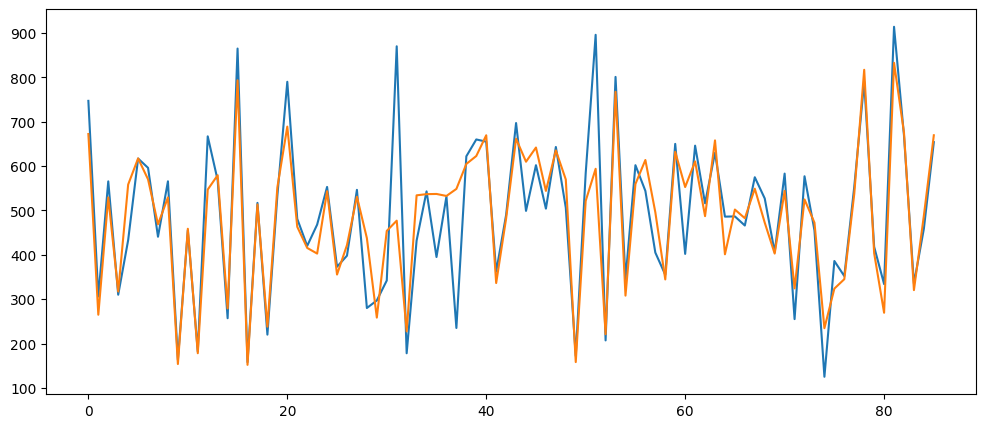

In [27]:
plt.figure(figsize = (12,5))
plt.plot(range(len(y_test)), y_test)
plt.plot(range(len(y_pred)), y_pred);

In [28]:
model_performance_df = pd.DataFrame(columns = ["Model Name", "Train R2 Score", "Test R2 Score" ,"Overall R2", "Train MAPE" , "Test MAPE" ,  "Overall MAPE"])
model_namer = {"lr" : "Linear",
               "ridge" : "Ridge",
               "lasso" : "Lasso",
               "rf" : "Random Forest",
               "svr" : "SVR",
               "dt" : "Decision Tree",
               "lgbm" : "LGBM",
                'mlp': "MLPRegressor",
               'elastic_net': "ElasticNet"
              }



for model_name, model_dict in best_models.items():
    model = model_dict["model"]
    y_pred = model.predict(X_test)
    train_pred = model.predict(X_train)
    total_pred = model.predict(X)
    error = total_pred - y

    model_performance_df  = pd.concat([model_performance_df, pd.DataFrame([{"Model Name" : model_namer.get(model_name),
                                                       "Train R2 Score" : r2_score(y_train, train_pred),
                                                       "Test R2 Score" : r2_score(y_test, y_pred),
                                                       "Overall R2" : r2_score(y, total_pred),
                                                       "Train MAPE" : mean_absolute_percentage_error(y_train, train_pred),
                                                       "Test MAPE" : mean_absolute_percentage_error(y_test, y_pred),
                                                       "Overall MAPE" : mean_absolute_percentage_error(y, total_pred),
                                                       "Error Variance" : error.var()
                                                      }])], ignore_index=True)
    
y_pred = stacked_model.predict(X_test)
train_pred = stacked_model.predict(X_train)
total_pred = stacked_model.predict(X)
error = total_pred - y
model_performance_df  = pd.concat([model_performance_df, pd.DataFrame([{"Model Name" : "Stacked",
                                                    "Train R2 Score" : r2_score(y_train, train_pred),
                                                    "Test R2 Score" : r2_score(y_test, y_pred),
                                                    "Overall R2" : r2_score(y, total_pred),
                                                    "Train MAPE" : mean_absolute_percentage_error(y_train, train_pred),
                                                    "Test MAPE" : mean_absolute_percentage_error(y_test, y_pred),
                                                    "Overall MAPE" : mean_absolute_percentage_error(y, total_pred),
                                                    "Error Variance" : error.var()
                                                    }])], ignore_index=True)


C:\Users\DEBS\AppData\Local\Temp\ipykernel_19148\1821869284.py:22: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  model_performance_df  = pd.concat([model_performance_df, pd.DataFrame([{"Model Name" : model_namer.get(model_name),


In [29]:
model_performance_df

,Model Name,Train R2 Score,Test R2 Score,Overall R2,Train MAPE,Test MAPE,Overall MAPE,Error Variance
0,Linear,0.359520,0.331014,0.360620,0.361102,0.273331,0.343383,21648.461435
1,Ridge,0.344190,0.316505,0.345604,0.369202,0.280538,0.351303,22156.160224
2,Lasso,0.333896,0.312562,0.336628,0.373163,0.281098,0.354577,22458.507203
3,Random Forest,0.901492,0.673038,0.858866,0.099154,0.156961,0.110824,4777.968677
4,SVR,0.841622,0.757095,0.827097,0.155060,0.158020,0.155657,5854.307092
5,Decision Tree,0.797282,0.414196,0.726188,0.163414,0.224005,0.175646,9272.277645
6,LGBM,0.687247,0.502907,0.655236,0.247147,0.234154,0.244524,11677.329092
7,ElasticNet,0.091624,0.031798,0.089480,0.482131,0.352604,0.455982,30769.710995
8,Stacked,0.890450,0.781346,0.870732,0.100119,0.122137,0.104564,4376.546049


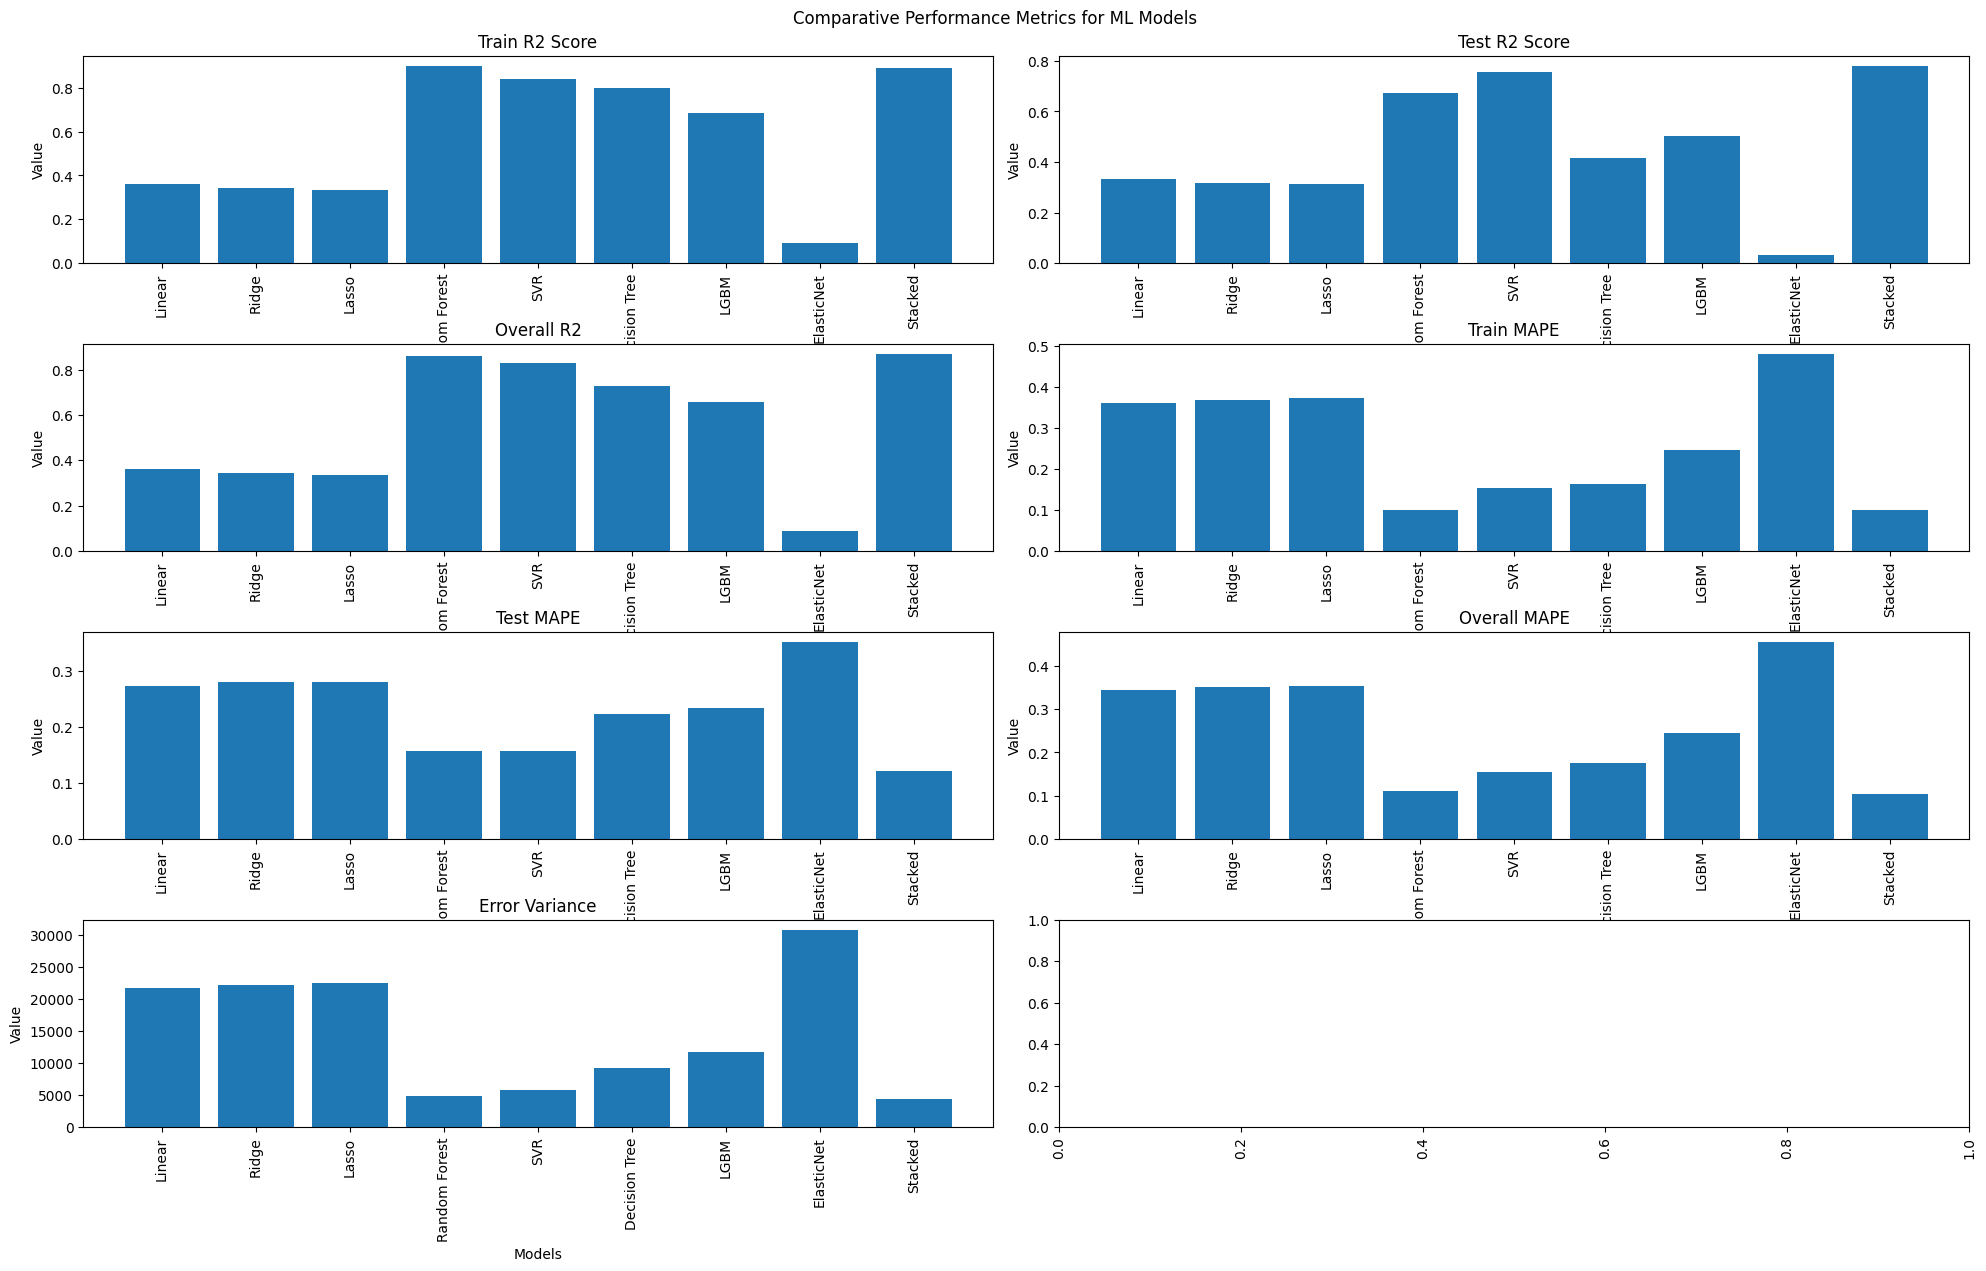

In [30]:

models = model_performance_df['Model Name'].tolist()
metrics_columns = model_performance_df.columns[1:]  # Exclude the 'Model' column


num_metrics = len(metrics_columns)
num_cols = 2  
num_rows = (num_metrics + 1) // num_cols

# Create subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 3*num_rows))
fig.suptitle('Comparative Performance Metrics for ML Models')


if num_rows == 1 or num_cols == 1:
    axs = axs.reshape(-1)
else:
    axs = axs.flatten()


for i, metric_col in enumerate(metrics_columns):
    row = i // num_cols
    col = i % num_cols
    ax = axs[row * num_cols + col]
    
    ax.bar(models, model_performance_df[metric_col])
    ax.set_title(metric_col)
    ax.set_xlabel('Models')
    ax.set_ylabel('Value')

plt.tight_layout()
# plt.subplots_adjust(top=0.92)

for ax in axs:
    ax.tick_params(axis='x', rotation=90)

plt.show()


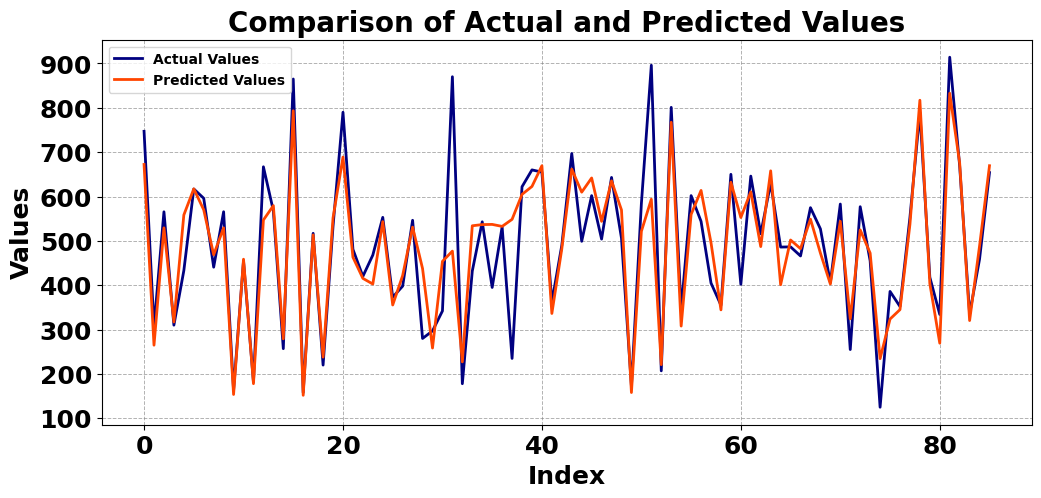

In [31]:
import matplotlib.pyplot as plt

# Your provided data
#y_test = [3, 5, 2, 8, 7, 9, 6, 4, 5, 3, 2, 6, 7, 8, 5]
#y_pred = [2.5, 5.1, 1.8, 7.5, 6.9, 8.7, 5.9, 4.3, 5.2, 3.1, 2.3, 6.5, 7.2, 8.1, 4.8]

# Set the figure size
plt.figure(figsize=(12, 5))

# Plot y_test and y_pred with deep red and green colors
plt.plot(range(len(y_test)), y_test, color='navy', label='Actual Values', linewidth=2)
plt.plot(range(len(y_pred)), y_pred, color='orangered', label='Predicted Values', linewidth=2)

# Add grid lines
plt.grid(True, which='both', linestyle='--', linewidth=0.7, color='gray', alpha=0.6)

# Add a legend
plt.legend(fontsize=18, loc='upper left', frameon=True, prop={'weight': 'bold'})

# Set the labels, title, and ticks with bold font
plt.xlabel('Index', fontsize=18, fontweight='bold')
plt.ylabel('Values', fontsize=18, fontweight='bold')
plt.title('Comparison of Actual and Predicted Values', fontsize=20, fontweight='bold')

# Set the x and y axis tick labels to bold
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')

# Display the plot
plt.show()
